In [23]:
# Packages

import selfies as sf
import pathlib as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pyarrow as pa

In [13]:
# Loading df_mofs_v3 (standardized) via parquet to retain types

df_mofs_v3 = pd.read_parquet(r"C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\df_mofs_v3.parquet")

In [14]:
df_mofs_v3.columns

Index(['MOFid', 'metal', 'linker', 'logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000', 'LCD', 'PLD', 'LFPD', 'cm3_g',
       'ASA_m2_cm3', 'ASA_m2_g', 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF',
       'AV_cm3_g', 'NAV_cm3_g', 'All_Metals', 'Has_OMS', 'Open_Metal_Sites',
       'metal_ids', 'metal_oms_flags', 'linker_ids'],
      dtype='object')

In [15]:
# Help functions

def stratified_split(df, target_col='logKH_CO2', test_size=0.1, val_size=0.1, random_state=42):
    """
    타겟 분포를 고려해서 데이터 나누기
    
    df: 데이터프레임
    target_col: 중요한 타겟 컬럼 (이 값의 분포가 골고루 나뉨)
    test_size: 테스트 비율 (0.1 = 10%)
    val_size: 검증 비율 (0.1 = 10%)
    """
    # 타겟을 5개 구간으로 나눔 (낮음, 중하, 중간, 중상, 높음)
    df['_group'] = pd.qcut(df[target_col], q=5, labels=False, duplicates='drop')
    
    # 1단계: Train+Val vs Test 분리
    train_val, test = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['_group'],  # 각 구간에서 골고루 뽑기
        random_state=random_state
    )
    
    # 2단계: Train vs Val 분리
    val_ratio = val_size / (1 - test_size)  # 남은 데이터에서 val 비율 계산
    train, val = train_test_split(
        train_val,
        test_size=val_ratio,
        stratify=train_val['_group'],
        random_state=random_state
    )
    
    # 임시로 만든 '_group' 컬럼 삭제
    train = train.drop(columns=['_group'])
    val = val.drop(columns=['_group'])
    test = test.drop(columns=['_group'])
    
    # 결과 출력
    print(f"Train: {len(train)} ({len(train)/len(df)*100:.1f}%)")
    print(f"Val:   {len(val)} ({len(val)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} ({len(test)/len(df)*100:.1f}%)")
    print(f"\n{target_col} 평균:")
    print(f"Train: {train[target_col].mean():.3f}")
    print(f"Val:   {val[target_col].mean():.3f}")
    print(f"Test:  {test[target_col].mean():.3f}")
    
    return train, val, test

def plot_split_distributions(train_df, val_df, test_df, columns):
    """Train/Val/Test 분포 시각적 비교"""
    fig, axes = plt.subplots(1, len(columns), figsize=(5*len(columns), 4))
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        axes[i].hist(train_df[col], alpha=0.5, label='Train', bins=30, density=True)
        axes[i].hist(val_df[col], alpha=0.5, label='Val', bins=30, density=True)
        axes[i].hist(test_df[col], alpha=0.5, label='Test', bins=30, density=True)
        axes[i].set_title(col)
        axes[i].legend()
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()




In [16]:

# Train / Val / Test dataset split
train_df, val_df, test_df = stratified_split(
    df_mofs_v3, 
    target_col='logKH_CO2',  # 가장 중요한 타겟 하나만
    test_size=0.1,           # 10% 테스트
    val_size=0.1             # 10% 검증
)

# Saving Train / Val / Test dataset in parquet forms.

train_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\train_df.parquet', index=False)
val_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\val_df.parquet', index=False)
test_df.to_parquet(r'C:\Users\dalja\OneDrive\Desktop\APS360 Project\MOF_processed data\test_df.parquet', index=False)

Train: 2665 (80.0%)
Val:   334 (10.0%)
Test:  334 (10.0%)

logKH_CO2 평균:
Train: -0.001
Val:   -0.006
Test:  0.016


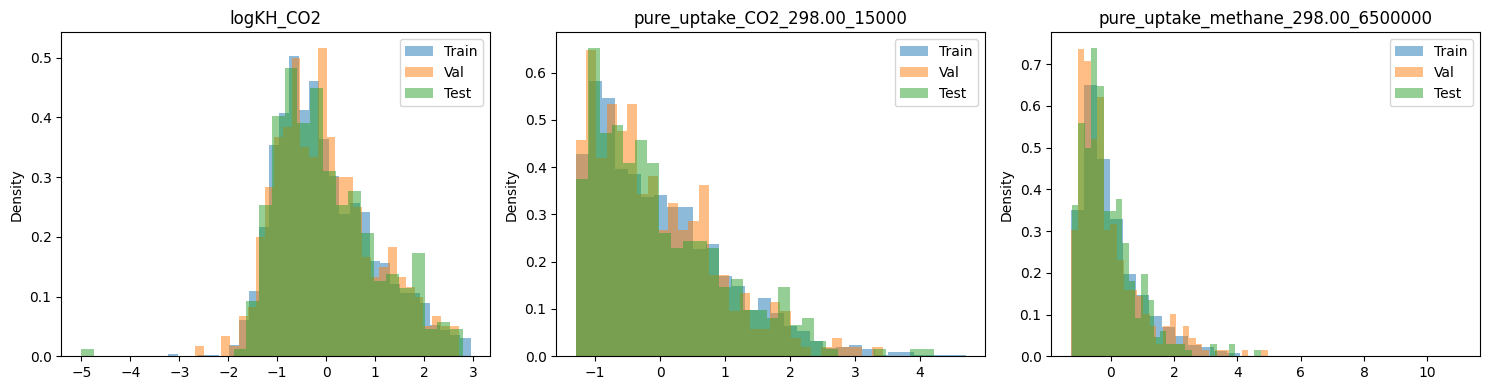

In [17]:
# Distribution of Train / Val / Test datasets; looking for similarity

plot_split_distributions(
    train_df, 
    val_df, 
    test_df, 
    columns=['logKH_CO2', 'pure_uptake_CO2_298.00_15000',
       'pure_uptake_methane_298.00_6500000']
)

In [ ]:
class MOFDataset(Dataset):
    def __init__(self, df, geometry_cols, target_cols):
        self.df = df
        self.geometry_cols = geometry_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            geometry = torch.tensor(
                row[self.geometry_cols].values.astype(np.float32), 
                dtype=torch.float32
            )
            
            metal_ids = torch.tensor(
                row['metal_ids'], 
                dtype=torch.long
            )
            
            metal_oms = torch.tensor(
                row['metal_oms_flags'], 
                dtype=torch.float32
            )
            
            linker_ids = torch.tensor(
                row['linker_ids'], 
                dtype=torch.long
            )
            
            targets = torch.tensor(
                row[self.target_cols].values.astype(np.float32), 
                dtype=torch.float32
            )
            
            return {
                'geometry': geometry,
                'metal_ids': metal_ids,
                'metal_oms': metal_oms,
                'linker_ids': linker_ids,
                'targets': targets
            }

In [19]:
geometry_cols = ['LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 
                 'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g']

target_cols = ['logKH_CO2', 'pure_uptake_CO2_298.00_15000', 
               'pure_uptake_methane_298.00_6500000']

# 재생성
train_dataset = MOFDataset(train_df, geometry_cols, target_cols)
val_dataset = MOFDataset(val_df, geometry_cols, target_cols)
test_dataset = MOFDataset(test_df, geometry_cols, target_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 84
Val batches: 11
Test batches: 11


In [22]:
import joblib

metal_vocab = joblib.load('metal_vocabulary.pkl')
print(f"Metal vocab type: {type(metal_vocab)}")
print(f"Metal vocab: {metal_vocab}")

linker_vocab = joblib.load('linker_vocabulary.pkl')
print(f"\nLinker data type: {type(linker_vocab)}")
print(f"Metal vocab: {linker_vocab}")

Metal vocab type: <class 'dict'>
Metal vocab: {'[nop]': 0, 'Ag': 1, 'Al': 2, 'Au': 3, 'Ba': 4, 'Be': 5, 'Bi': 6, 'Ca': 7, 'Cd': 8, 'Ce': 9, 'Co': 10, 'Cr': 11, 'Cs': 12, 'Cu': 13, 'Dy': 14, 'Er': 15, 'Eu': 16, 'Fe': 17, 'Ga': 18, 'Gd': 19, 'Hf': 20, 'Ho': 21, 'In': 22, 'Ir': 23, 'K': 24, 'La': 25, 'Li': 26, 'Lu': 27, 'Mg': 28, 'Mn': 29, 'Mo': 30, 'Na': 31, 'Nb': 32, 'Nd': 33, 'Ni': 34, 'Pb': 35, 'Pd': 36, 'Pr': 37, 'Pt': 38, 'Rb': 39, 'Re': 40, 'Rh': 41, 'Ru': 42, 'Sm': 43, 'Sn': 44, 'Sr': 45, 'Tb': 46, 'Th': 47, 'Tm': 48, 'U': 49, 'V': 50, 'W': 51, 'Y': 52, 'Yb': 53, 'Zn': 54}

Linker data type: <class 'dict'>
Metal vocab: {'[nop]': 0, '[#Branch1]': 1, '[#Branch2]': 2, '[#CH0]': 3, '[#C]': 4, '[#N]': 5, '[/-Ring1]': 6, '[/-Ring2]': 7, '[/Br]': 8, '[/C@@H1]': 9, '[/C@@]': 10, '[/C@H1]': 11, '[/C@]': 12, '[/CH0]': 13, '[/CH1]': 14, '[/C]': 15, '[/NH0]': 16, '[/NH1]': 17, '[/N]': 18, '[/S]': 19, '[=Branch1]': 20, '[=Branch2]': 21, '[=CH0]': 22, '[=CH1]': 23, '[=C]': 24, '[=N+1]': 25, '[=

In [24]:
def add_positional_encoding(x, pos_embedding):
    """
    Positional encoding 추가
    
    Args:
        x: (batch, seq_len, d_model)
        pos_embedding: nn.Embedding layer
    Returns:
        x + positional encoding
    """
    seq_len = x.shape[1]
    positions = torch.arange(seq_len, device=x.device)
    pos_emb = pos_embedding(positions)
    return x + pos_emb.unsqueeze(0)

In [26]:
class MOFTransformer(nn.Module):
    """MOF Property Prediction Model"""
    
    def __init__(
        self,
        num_metals=55,
        num_linker_tokens=86,
        d_model=256,
        nhead=8,
        num_layers=6
    ):
        super().__init__()
        
        # Embeddings
        self.metal_emb = nn.Embedding(num_metals, d_model)
        self.linker_emb = nn.Embedding(num_linker_tokens, d_model)
        self.special_emb = nn.Embedding(3, d_model)  # [PAD], [CLS], [SEP]
        self.pos_emb = nn.Embedding(500, d_model)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Geometric MLP
        self.geo_mlp = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
        
        # Prediction MLP
        self.predictor = nn.Sequential(
            nn.Linear(d_model + 128, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        
        self.cls_id = 1
        self.sep_id = 2
    
    def forward(self, metal_ids, linker_ids, geometry):
        """
        Args:
            metal_ids: (batch, 5)
            linker_ids: (batch, linker_len)
            geometry: (batch, 11)
        Returns:
            predictions: (batch, 3)
        """
        batch_size = metal_ids.shape[0]
        device = metal_ids.device
        
        # === PRECURSOR BRANCH ===
        # 1. Embeddings
        metal_emb = self.metal_emb(metal_ids)  # (batch, 5, d_model)
        linker_emb = self.linker_emb(linker_ids)  # (batch, linker_len, d_model)
        
        # 2. Special tokens
        cls_ids = torch.full((batch_size, 1), self.cls_id, dtype=torch.long, device=device)
        cls_token = self.special_emb(cls_ids)  # (batch, 1, d_model)
        
        sep_ids = torch.full((batch_size, 1), self.sep_id, dtype=torch.long, device=device)
        sep_token = self.special_emb(sep_ids)  # (batch, 1, d_model)
        
        # 3. Sequence
        sequence = torch.cat([cls_token, metal_emb, sep_token, linker_emb], dim=1)
        
        # 4. Positional encoding
        sequence = add_positional_encoding(sequence, self.pos_emb)
        
        # 5. Transformer
        transformer_out = self.transformer(sequence)
        precursor_emb = transformer_out[:, 0, :]  # [CLS] token
        
        # === GEOMETRIC BRANCH ===
        geometric_emb = self.geo_mlp(geometry)
        
        # === FUSION ===
        combined = torch.cat([precursor_emb, geometric_emb], dim=-1)
        predictions = self.predictor(combined)
        
        return predictions

In [27]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """1 epoch 학습"""
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        # Data to device
        metal_ids = batch['metal_ids'].to(device)
        linker_ids = batch['linker_ids'].to(device)
        geometry = batch['geometry'].to(device)
        targets = batch['targets'].to(device)
        
        # Forward
        predictions = model(metal_ids, linker_ids, geometry)
        
        # Loss
        loss = criterion(predictions, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Data to device
            metal_ids = batch['metal_ids'].to(device)
            linker_ids = batch['linker_ids'].to(device)
            geometry = batch['geometry'].to(device)
            targets = batch['targets'].to(device)
            
            # Forward
            predictions = model(metal_ids, linker_ids, geometry)
            
            # Loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-4, device='cuda'):
    """전체 학습 과정"""
    
    # Loss & Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Move model to device
    model = model.to(device)
    
    # Training loop
    for epoch in range(num_epochs):
        # Train
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    print("Training complete!")
    return model

In [28]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
model = MOFTransformer()

# Train
trained_model = train_model(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=100,
    device=device
)

Epoch 10/100 - Train Loss: 0.3161, Val Loss: 0.3378
Epoch 20/100 - Train Loss: 0.2039, Val Loss: 0.4237
Epoch 30/100 - Train Loss: 0.1263, Val Loss: 0.3955
Epoch 40/100 - Train Loss: 0.0691, Val Loss: 0.4165
Epoch 50/100 - Train Loss: 0.0481, Val Loss: 0.4039
Epoch 60/100 - Train Loss: 0.0374, Val Loss: 0.4600
Epoch 70/100 - Train Loss: 0.0291, Val Loss: 0.4374
Epoch 80/100 - Train Loss: 0.0253, Val Loss: 0.4208
Epoch 90/100 - Train Loss: 0.0220, Val Loss: 0.4187
Epoch 100/100 - Train Loss: 0.0185, Val Loss: 0.4243
Training complete!
